In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import boto3
import matplotlib.pyplot as plt

# Initialize S3
s3 = boto3.client('s3')

# S3 paths
bucket_name = 'nexttrendco'
train_path = 'walmart/train.csv'
val_path = 'walmart/val.csv'
test_path = 'walmart/test.csv'

# Load data from S3
train_walmart = pd.read_csv(f's3://{bucket_name}/{train_path}')
val_walmart = pd.read_csv(f's3://{bucket_name}/{val_path}')
test_walmart = pd.read_csv(f's3://{bucket_name}/{test_path}')

# Print
print("Train Walmart DataFrame:")
print(train_walmart.head())

print("\nValidation Walmart DataFrame:")
print(val_walmart.head())

print("\nTest Walmart DataFrame:")
print(test_walmart.head())

Train Walmart DataFrame:
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Validation Walmart DataFrame:
   Store  Dept        Date  Weekly_Sales  IsHoliday     lag_1     lag_7  \
0      1     1  2010-03-12      21043.39      False  21827.90       NaN   
1      1     1  2010-05-07      17413.94      False  16555.11  22136.64   
2      1     1  2010-05-21      14773.04      False  18926.74  57258.43   
3      1     1  2010-06-11      16637.62      False  17558.09  16145.35   
4      1     1  2010-06-18      16216.27      False  16637.62  16555.11   

   rolling_mean_7  holiday_sales_interaction  day_of_week  month  
0             NaN                        0.0            4      3  
1    27737.130000                        0.0   

In [22]:
# Preprocess the data: Drop 'Date' column and separate the target variable 'Weekly_Sales'
train_walmart = train_walmart.drop(columns=['Date'], errors='ignore')
val_walmart = val_walmart.drop(columns=['Date'], errors='ignore')

In [23]:
# Feature Engineering
# Create lag features
train_walmart['lag_1'] = train_walmart['Weekly_Sales'].shift(1)
train_walmart['lag_7'] = train_walmart['Weekly_Sales'].shift(7)
train_walmart['rolling_mean_7'] = train_walmart['Weekly_Sales'].rolling(window=7).mean()

val_walmart['lag_1'] = val_walmart['Weekly_Sales'].shift(1)
val_walmart['lag_7'] = val_walmart['Weekly_Sales'].shift(7)
val_walmart['rolling_mean_7'] = val_walmart['Weekly_Sales'].rolling(window=7).mean() 

# Drop NaN values created by the lag features
train_walmart.dropna(inplace=True)
val_walmart.dropna(inplace=True)

# Define features and target for training and validation
X_train_walmart = train_walmart.drop(columns=['Weekly_Sales'])
y_train_walmart = train_walmart['Weekly_Sales']

X_val_walmart = val_walmart.drop(columns=['Weekly_Sales'])
y_val_walmart = val_walmart['Weekly_Sales']

# Ensure validation features match  training features
X_val_walmart = X_val_walmart.reindex(columns=X_train_walmart.columns, fill_value=0)

# Preview
print("Train DataFrame with Lag Features:")
print(train_walmart.head())

print("Validation DataFrame with Lag Features:")
print(val_walmart.head())

Train DataFrame with Lag Features:
    Store  Dept  Weekly_Sales  IsHoliday     lag_1     lag_7  rolling_mean_7
7       1     1      26229.21      False  22136.64  24924.50    28325.102857
8       1     1      57258.43      False  26229.21  46039.49    29927.808571
9       1     1      42960.91      False  57258.43  41595.55    30122.860000
10      1     1      17596.96      False  42960.91  19403.54    29864.777143
11      1     1      16145.35      False  17596.96  21827.90    29052.984286
Validation DataFrame with Lag Features:
    Store  Dept  Weekly_Sales  IsHoliday     lag_1     lag_7  rolling_mean_7  \
7       1     1      26978.34      False  19354.23  21043.39    18129.977143   
8       1     1      25543.04      False  26978.34  17413.94    19291.277143   
9       1     1      22517.56      False  25543.04  14773.04    20397.637143   
10      1     1      44912.86      False  22517.56  16637.62    24436.957143   
11      1     1      19124.58       True  44912.86  16216.27   

In [24]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train model on the training data
rf_model.fit(X_train_walmart, y_train_walmart)

# Predict on the validation data
y_val_pred = rf_model.predict(X_val_walmart)

# Evaluate model on validation data
mae = mean_absolute_error(y_val_walmart, y_val_pred)
rmse = mean_squared_error(y_val_walmart, y_val_pred, squared=False)

print(f"Validation MAE: {mae}")
print(f"Validation RMSE: {rmse}")

Validation MAE: 3025.6301153696613
Validation RMSE: 7894.877532060235


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
# Prepare features for the test set
X_test_walmart = test_walmart.drop(columns=['Date'], errors='ignore')

# Ensure the test features match with the training features 
X_test_walmart = X_test_walmart.reindex(columns=X_train_walmart.columns, fill_value=0)

# Predict on the test data 
y_test_pred = rf_model.predict(X_test_walmart)

# Display first 5 predictions on test data
print(f"First 5 Predictions on Test Data: {y_test_pred[:5]}")

First 5 Predictions on Test Data: [17.691 17.691 17.691 14.887 17.691]


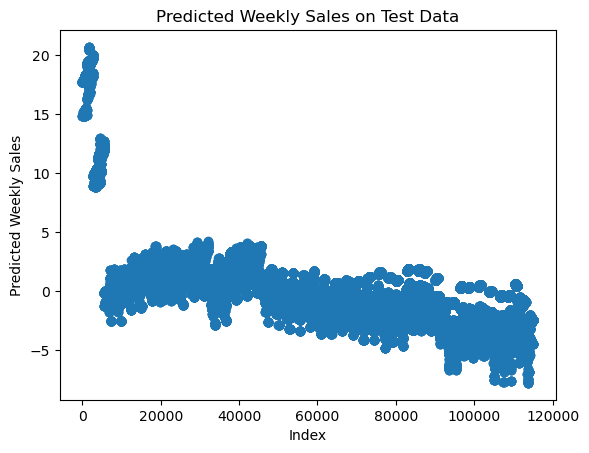

In [27]:
# Plot actual vs predicted for test data 
plt.scatter(range(len(y_test_pred)), y_test_pred)
plt.xlabel('Index')
plt.ylabel('Predicted Weekly Sales')
plt.title('Predicted Weekly Sales on Test Data')
plt.show()

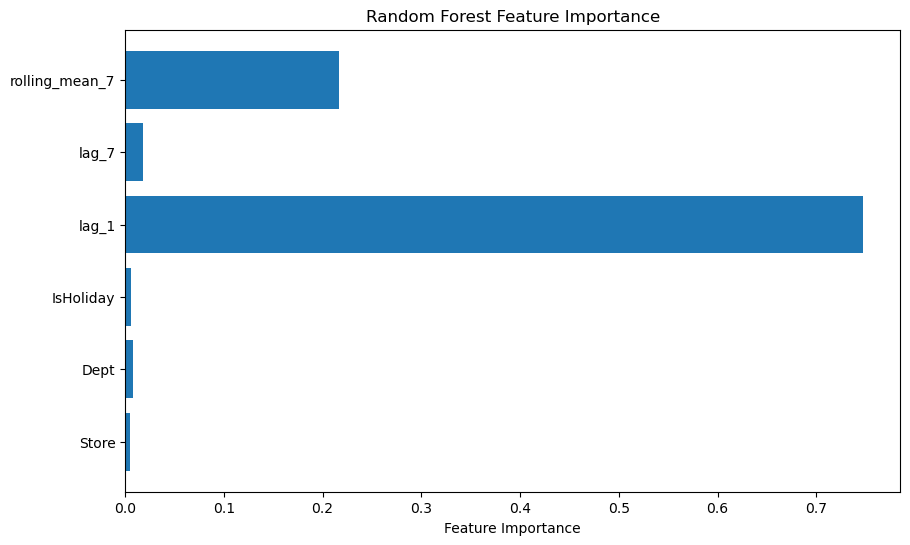

In [28]:
# Feature importance
importances = rf_model.feature_importances_
features = X_train_walmart.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

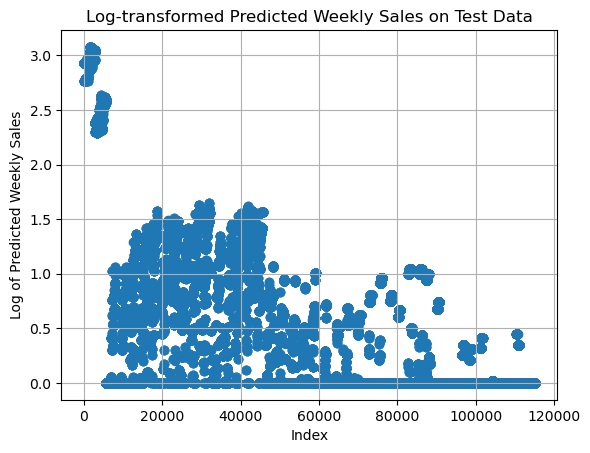

In [29]:
# Log transformation on predictions 
y_test_pred_clean = np.where(y_test_pred <= 0, 1e-5, y_test_pred)  
y_test_pred_log = np.log1p(y_test_pred_clean)  

# Plot Log-transformed predictions
plt.scatter(range(len(y_test_pred_log)), y_test_pred_log)
plt.xlabel('Index')
plt.ylabel('Log of Predicted Weekly Sales')
plt.title('Log-transformed Predicted Weekly Sales on Test Data')
plt.grid(True)
plt.show()